### Summarizing Alignment Statistics

The final bam file will have the name (or suffix) ```*star_gene_exon_tagged.bam``` We are going to take a look at that file on the command line to see how all the information about alignment is stored. 

Samtools is the package that allows us to view and manipulate sam/bam files. Let's use ```samtools view``` to look at the bam file. We are going to pipe the results into less -S which will allow us to scroll through the file, displaying one line at a time (no text wrapping). Make sure to insert the name of your bamfile in the command below.

```bash
samtools view bamfile | less -S```

Let's take a look at one entry in the bam file. This read mapped to the coding sequence of the gene Ppp1r14c. 

```bash

SRR1853178.360590975    0       10      3366531 255     60M     *       0       0       CCGCAAGGATCCAGCGTCTAGGCGCGCGGAGCAGGTGCGGGCCACCGTATGCGGCTGTTG    A<AAAFFFFFFF<FFAAF<.FFFFAFFF7.FFFFFFFFFA.FF.FFFFA)FFFFFFF7<F    XC:Z:AGTGGGATAGTC       MD:Z:60 GE:Z:Ppp1r14c   XF:Z:CODING     PG:Z:STAR       RG:Z:A  NH:i:1  NM:i:0  XM:Z:TCTCTTTT   UQ:i:0  AS:i:59 GS:Z:+```

Dropseqtools stores the cell barcode with the XC tag, UMI in the XM tag, and gene name in the GE tag. We are going to use these fields to parse and get information about summary statistics on how our reads mapped to cell barcodes, and duplication rates for UMIs.

## Running qc scripts

**1) Softlink scripts**

```bash
mkdir -p ~/jupyter_notebooks/macosko_results/
cd ~/jupyter_notebooks/macosko_analysis/
ln -s /oasis/tscc/scratch/cshl_2018/shared_scripts/dropseqtools_qc.py ./
```

**2) Install a few more packages in py3 environment**

```bash
source activate py3_cshl
conda install pysam tqdm 
```

Once the installs have finished, get out of the environment with: 
```bash
source deactivate
source ~/.bashrc
```

## Using Jupyter to run qc scripts

**1) Load Jupyter Notebook**

Follow the instructions [here](https://github.com/ecwheele/CSHL_singlecellanalyses_2018/blob/master/tutorials/How_to_load_jupyter_notebooks.ipynb). Make a folder in your home with all your analyses notebooks:


Once your notebooks are loaded, open a new notebook in the macosko_results folder using the python3 kernel that comes from our py3_cshl environment

**2) Import required packages**

For this analysis we will only be using the dropseqtools_qc script, so import that and give it a shorthand notation (dq). 

In [5]:
import dropseqtools_qc as dq
import pandas as pd

**3) Define folders and files**
We will use variables to store the full path of commonly used folders. In the code below, ```results_dir``` is a variable that contains data in the form of a string and now stores the full path information of where the results are located. A string can be anything between quotation marks. You can combine strings with a ```+``` as shown when appending the name of the bam file to the full path. 

In [6]:
results_dir = "/home/ucsd-train25/cshl_2018/dropseqtools_results_macosko/batch1_full/"
save_dir = "/projects/ps-yeolab3/ecwheele/cshl_2018/test_macosko_full_batch1/"

In [7]:
bamfile = results_dir+"12_my_clean.sorted.bam"

**4) Count the number of reads mapping to each cell barcode**

The dropseqtools_qc script has a function called ```get_cell_barcode_counts```. You can call it with the name of the package followed by a dot and a function name. 

In [8]:
cell_bc_counts = dq.get_cell_barcode_counts(bamfile, save_dir+"cell_barcode_counts.pickle")

**5) Analyze umi and gene counts per cell barcode**

In [9]:
cell_barcodes_to_analyze = dq.get_cell_barcodes_to_analyze(cell_bc_counts)

In [10]:
umi_counts = dq.make_df_for_kneeplot(bamfile, cell_barcodes_to_analyze, save_dir+"barcodes_genes_umi.pickle")

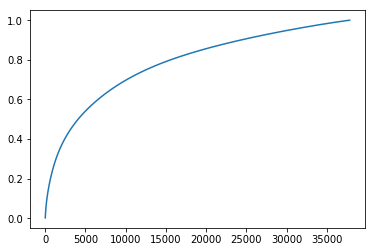

In [11]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

plt.plot(umi_counts['cumulative'].values)

**6) Call number of cells from kneeplot**

Where is the inflection point in this curve? In this dataset, 6600 cells were called. From the downsampled dataset, you will likely call much fewer cells. 

In [12]:
number_of_cells = 6600

Since the rows in the dataframe are sorted in descending order with the number of barcodes, we can grab the 6600 with the most reads with head(6600) and save those barcodes to a file. 

In [13]:
cell_barcodes_to_keep = pd.DataFrame(index = umi_counts.head(number_of_cells).index)

In [14]:
cell_barcodes_to_keep.head()

""
cell_barcode
GGCCGCAGTCCG
CTTGTGCGGGAA
GCGCAACTGCTC
AGTCAAGCCCTC
GATTGGGAGGCA


In [15]:
cell_barcodes_to_keep.to_csv(save_dir+"cell_barcodes_to_keep.csv")